In [1]:
 from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
import tensorflow as tf
import os
from os import chdir as cd
import warnings
import cv2
import pickle
import random
from matplotlib import gridspec   
from matplotlib import cm
from scipy import interpolate
from scipy import stats
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsOneClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from tqdm import tqdm
import itertools
import functools
from functools import partial
from tensorflow.keras import backend as K 
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.metrics import top_k_categorical_accuracy as tCA
from tensorflow.keras.metrics import Recall
from tensorflow.keras.metrics import CategoricalCrossentropy
from tensorflow.keras.regularizers import l1,l2,l1_l2
from tensorflow.keras.optimizers import Adam, RMSprop , SGD
from tensorflow.keras.layers import add, concatenate, multiply
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Input, Concatenate, GlobalMaxPooling2D, Reshape , Lambda , Add, Multiply, LeakyReLU
from tensorflow.keras.layers import Conv2D, MaxPool2D, Conv2DTranspose, UpSampling2D, BatchNormalization, MaxPooling2D, Flatten, GlobalAveragePooling2D, Activation, AveragePooling2D , ZeroPadding2D, SeparableConv2D, Dropout
from tensorflow.keras.models import Model, load_model , Sequential
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.callbacks import EarlyStopping , LearningRateScheduler, ModelCheckpoint, CSVLogger, Callback, ReduceLROnPlateau
warnings.filterwarnings("ignore")

In [3]:
cd("/content/drive/Shareddrives/Labs/2020_1_이소연/code")
from lrn import LRN
from f1score import macro_f1score
labels = ['Center','Edge-Loc','Edge-Ring','Loc','Near-full','Scratch','none']

In [ ]:
!cat /proc/cpuinfo

# **Preprocessing**

In [ ]:
os.chdir("/content/drive/Shareddrives/Labs/2020_1_이소연/code")
df=pd.read_pickle("LSWMD.pkl")
df = df.drop(['waferIndex'], axis = 1)
def find_dim(x):
    dim0=np.size(x,axis=0)
    dim1=np.size(x,axis=1)
    return dim0,dim1
df['waferMapDim']=df.waferMap.apply(find_dim)
# Mapping
df['failureNum'] = df.failureType
df['trainTestNum'] = df.trianTestLabel
mapping_type = {'Center':0,'Donut':1,'Edge-Loc':2,'Edge-Ring':3,'Loc':4,'Random':5,'Scratch':6,'Near-full':7,'none':8}
mapping_traintest = {'Training':0,'Test':1}
df=df.replace({'failureNum':mapping_type, 'trainTestNum':mapping_traintest})
# label, pattern
tol_wafers = df.shape[0]
df_withlabel = df[(df['failureNum']>=0) & (df['failureNum']<=8)]
df_withlabel =df_withlabel.reset_index()
df_withpattern = df[(df['failureNum']>=0) & (df['failureNum']<=7)]
df_withpattern = df_withpattern.reset_index() 
df_nonpattern = df[(df['failureNum']==8)]
sub_df = df_withlabel.loc[(df_withlabel['waferMapDim'] == (33, 29)) | (df_withlabel['waferMapDim'] == (41, 33))].reset_index(drop=True)
sub_df['waferMap']=sub_df.waferMap.apply(lambda x: cv2.resize(x, dsize=(32,32), interpolation = cv2.INTER_NEAREST))
sub_df.to_pickle("main2.pkl")

In [4]:
sub_df = pd.read_pickle("main2.pkl")

In [5]:
sub_df.head()

,index,waferMap,dieSize,lotName,trianTestLabel,failureType,waferMapDim,failureNum,trainTestNum
0,9637,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,...",741.0,lot1847,[[Training]],[[Edge-Loc]],"(33, 29)",2,0
1,13741,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,...",741.0,lot2137,[[Training]],[[Scratch]],"(33, 29)",6,0
2,13765,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,...",741.0,lot2138,[[Training]],[[Scratch]],"(33, 29)",6,0
3,14503,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,...",741.0,lot2172,[[Training]],[[Edge-Loc]],"(33, 29)",2,0
4,14528,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,...",741.0,lot2173,[[Training]],[[Edge-Loc]],"(33, 29)",2,0


In [6]:
sub_df.shape

(13216, 9)

In [7]:
sub_df = sub_df.loc[(sub_df['failureType'] != 'Donut') & (sub_df['failureType'] != 'Random')]
sub_df.shape

(13197, 9)

In [8]:
# Plotting
sw = np.ones((1, 32, 32))
label = list()

for i in tqdm(range(len(sub_df))):
    if len(sub_df.iloc[i,:]['failureType']) == 0:
        continue
    sw = np.concatenate((sw, sub_df.iloc[i,:]['waferMap'].reshape(1, 32, 32)))
    label.append(sub_df.iloc[i,:]['failureType'][0][0])
x = sw[1:]
y = np.array(label).reshape((-1,1))

100%|██████████| 13197/13197 [02:38<00:00, 83.12it/s]


In [9]:
for f in labels :
    print('{} : {}'.format(f, len(y[y==f])))

Center : 61
Edge-Loc : 260
Edge-Ring : 68
Loc : 177
Near-full : 32
Scratch : 91
none : 12508


In [10]:
# Stratified train/test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=123, stratify=y)

In [11]:
for f in labels :
    print('{} : {}'.format(f, len(y_test[y_test==f])))

Center : 24
Edge-Loc : 104
Edge-Ring : 27
Loc : 71
Near-full : 13
Scratch : 37
none : 5003


In [12]:
print('{},{}'.format(x_train.shape, y_train.shape))

(7918, 32, 32),(7918, 1)


# **Bernoulli Bootstrap with p=0.05**

Failure type : ['Edge-Loc'] 


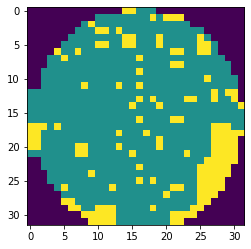

In [ ]:
plt.imshow(x[0])
print('Failure type : {} '.format(y[0]))

Failure type : ['Edge-Loc'] 


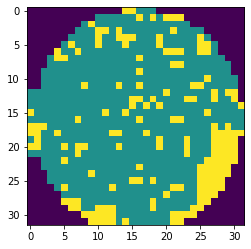

In [ ]:
plt.imshow(np.argmax(x_new[0],axis=2))
print('Failure type : {} '.format(y[0]))

In [13]:
def aply(ary):
  lst = [z+np.random.binomial(1,p=0.05) if z != 0 else z for z in ary]
  lst = [1 if z == 3 else z for z in lst]
  return lst

In [14]:
# Generate data
def gen_data(wafer, label):
    gen_x = []
    for i in tqdm(range((7000//len(wafer)) + 1)):
      for lst in wafer:
        gen_x.append(np.array(list(map(aply, lst))))
    # gen_x = np.concatenate((wafer, temp))   
    gen_y = np.full((len(gen_x), 1), label)
    
    return gen_x, gen_y

In [15]:
x_train_org = x_train.copy()
y_train_org = y_train.copy()

In [25]:
for f in labels :  
    if f == 'none' : 
        continue    
    g_x, g_y = gen_data(x_train[np.where(y_train==f)[0]], f)
    x_train = np.concatenate((x_train, g_x))
    y_train = np.concatenate((y_train, g_y))

100%|██████████| 130/130 [00:26<00:00,  4.83it/s]


In [26]:
print('After Generate new x shape : {}, new y shape : {}'.format(x_train.shape, y_train.shape))

After Generate new x shape : (50112, 32, 32), new y shape : (50112, 1)


In [27]:
for f in labels :
    print('{} : {}'.format(f, len(y_train[y_train==f]))) 

Center : 7067
Edge-Loc : 7176
Edge-Ring : 7052
Loc : 7208
Near-full : 7030
Scratch : 7074
none : 7505


In [28]:
def shuffle_two(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [29]:
x_train, y_train = shuffle_two(x_train, y_train)

Failure type : ['Scratch'] 


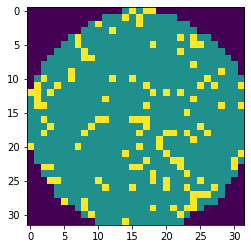

In [30]:
plt.imshow(x_train[442])
print('Failure type : {} '.format(y_train[442]))

In [32]:
# For CNN models
new_x_train = np.zeros((len(x_train), 32, 32, 3))
for w in tqdm(range(len(x_train))):
    for i in range(32):
        for j in range(32):
            new_x_train[w, i, j, int(x_train[w, i, j])] = 1

new_x_test = np.zeros((len(x_test), 32, 32, 3))
for w in tqdm(range(len(x_test))):
    for i in range(32):
        for j in range(32):
            new_x_test[w, i, j, int(x_test[w, i, j])] = 1

new_x_train.shape, new_x_test.shape

100%|██████████| 5279/5279 [00:04<00:00, 1254.72it/s]


((50112, 32, 32, 3), (5279, 32, 32, 3))

# **Saving dataset as pickle**

In [38]:
# # saving augmented x and y
# dataset_boot = {"new_x_train": new_x_train, "new_x_test": new_x_test, "y_train": y_train, "y_test": y_test, "x_train": x_train, "x_test": x_test}
# with open('dataset_boot.pickle', 'wb') as file:
#     pickle.dump(dataset_boot, file)

In [4]:
with open('dataset_boot.pickle', 'rb') as file:
    dataset_boot = pickle.load(file)

In [7]:
x_test = dataset_boot.get("new_x_test")
x_train = dataset_boot.get("new_x_train")
y_train = dataset_boot.get("y_train")
y_test = dataset_boot.get("y_test")

# **Convolutional Autoencoder**

In [ ]:
def encoder(input_img):
    #encoder
    #input = 32 x 32 x 3 (wide and thin)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    pool1 = MaxPooling2D(padding='same')(conv1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(padding='same')(conv2) # 8 x 8 x 64
    return pool2

def decoder(conv4):
    #decoder
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv4) # 8 x 8 x 64
    up1 = UpSampling2D()(conv5) # 16 x 16 x 64
    conv6 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1)
    conv6 = BatchNormalization()(conv6)
    up2 = UpSampling2D()(conv6)
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(up2) # 32 x 32 x 1
    return decoded

In [ ]:
input_shape = Input(shape=(32, 32, 3))

In [ ]:
AEncoder = Model(input_shape, decoder(encoder(input_shape)))
AEncoder.summary()
AEncoder.compile(loss='mse', optimizer='adam')
AEncoder.fit(x_train, x_train, epochs=10, batch_size=64, verbose=2)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
batch_normalization_10 (Batc (None, 16, 16, 64)        256       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 8, 8, 64)          3692

In [ ]:
np.where(y_test=='Edge-Loc')

(array([ 210,  275,  399,  535,  748,  752,  851,  883,  887,  997, 1007,
        1068, 1084, 1111, 1190, 1272, 1353, 1364, 1460, 1585, 1622, 1643,
        1775, 1794, 1845, 1855, 1936, 2043, 2081, 2089, 2100, 2120, 2219,
        2225, 2305, 2533, 2619, 2636, 2680, 2805, 2817, 2820, 2862, 2872,
        2913, 2929, 2977, 3064, 3077, 3104, 3111, 3153]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0]))

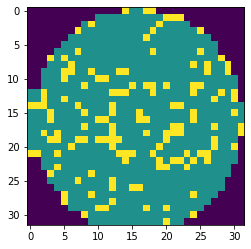

In [ ]:
plt.imshow(np.argmax(x_test[228], axis=2))

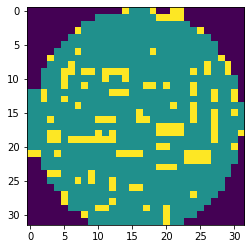

In [ ]:
gen_x = np.argmax(AEncoder.predict(x_test), axis=3)
plt.imshow(gen_x[228])

In [ ]:
x_train[0].shape

(32, 32, 3)

In [ ]:
np.where(y_train=='Edge-Loc')

(array([   5,   18,   29,   56,  107,  143,  264,  328,  766,  768,  778,
         856,  908,  983, 1027, 1032, 1065, 1087, 1089, 1225, 1242, 1391,
        1505, 1554, 1592, 1661, 1852, 1856, 1876, 1967, 2017, 2131, 2133,
        2264, 2360, 2440, 2541, 2645, 2780, 2883, 2927, 2954, 2955, 2972,
        3117, 3183, 3314, 3324, 3474, 3479, 3525, 3536, 3556, 3566, 3591,
        3627, 3697, 3836, 3845, 3854, 4029, 4034, 4094, 4176, 4246, 4266,
        4311, 4326, 4334, 4343, 4349, 4371, 4474, 4490, 4589, 4601, 4769,
        4800]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

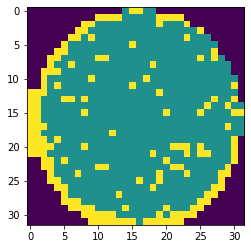

In [ ]:
plt.imshow(np.argmax(x_train[7], axis=2))

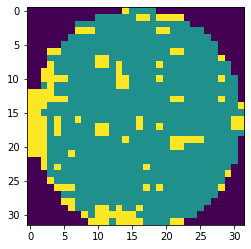

In [ ]:
gen_x = np.argmax(AEncoder.predict(x_train + np.random.normal(loc=0, scale=0.1, size = (4873, 32, 32, 3))), axis=3)
plt.imshow(gen_x[7])

In [ ]:
# Generate data
def gen_data(wafer, label):
    gen_x = np.zeros((1, 32, 32, 3))
    
    for i in tqdm(range((4000//len(wafer)) + 1)):
        noised_encoded_x = wafer + np.random.normal(loc=0, scale=0.1, size = (len(wafer), 32, 32, 3))  
        noised_gen_x = AEncoder.predict(noised_encoded_x)
        gen_x = np.concatenate((gen_x, noised_gen_x), axis=0)

    gen_y = np.full((len(gen_x), 1), label)
    
    return gen_x[1:], gen_y[1:]

In [ ]:
x_train_org = x_train.copy()
y_train_org = y_train.copy()
for f in labels :  
    if f == 'none' : 
        continue    
    gen_x, gen_y = gen_data(x_train[np.where(y_train==f)[0]], f)
    x_train = np.concatenate((x_train, gen_x), axis=0)
    y_train = np.concatenate((y_train, gen_y))

100%|██████████| 143/143 [00:10<00:00, 13.69it/s]


In [ ]:
np.where(y_train=='Edge-Ring')

(array([   24,   182,   278, ..., 16960, 16961, 16962]),
 array([0, 0, 0, ..., 0, 0, 0]))

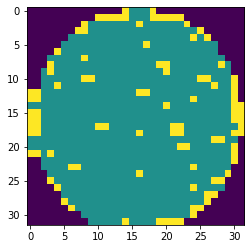

In [ ]:
plt.imshow(np.argmax(x_train[16962], axis=2))

In [ ]:
print('After Generate new x shape : {}, new y shape : {}'.format(x_train.shape, y_train.shape))

After Generate new x shape : (29004, 32, 32, 3), new y shape : (29004, 1)


In [ ]:
for f in labels :
    print('{} : {}'.format(f, len(y_train[y_train==f]))) 

Center : 4020
Edge-Loc : 4134
Edge-Ring : 4059
Loc : 4096
Near-full : 4029
Scratch : 4032
none : 4634


In [ ]:
def shuffle_two(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [ ]:
x_train, y_train = shuffle_two(x_train, y_train)

In [ ]:
x_test, y_test = shuffle_two(x_test, y_test)

In [ ]:
np.where(y_train=='Edge-Ring')

(array([    7,    14,    16, ..., 32998, 33011, 33013]),
 array([0, 0, 0, ..., 0, 0, 0]))

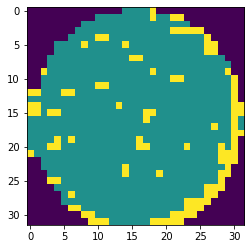

In [ ]:
plt.imshow(np.argmax(x_train[7], axis=2))

# **Apply CNN**

In [8]:
y_OH = OneHotEncoder()
y_train_ohe = y_OH.fit_transform(y_train)
print(y_OH.get_feature_names())
y_train_ohe = y_train_ohe.toarray()
print(y_train_ohe[291])

['x0_Center' 'x0_Edge-Loc' 'x0_Edge-Ring' 'x0_Loc' 'x0_Near-full'
 'x0_Scratch' 'x0_none']
[0. 0. 0. 0. 0. 0. 1.]


In [9]:
y_OH2 = OneHotEncoder()
y_test_ohe = y_OH2.fit_transform(y_test)
print(y_OH2.get_feature_names())
y_test_ohe = y_test_ohe.toarray()
print(y_test_ohe[133])

['x0_Center' 'x0_Edge-Loc' 'x0_Edge-Ring' 'x0_Loc' 'x0_Near-full'
 'x0_Scratch' 'x0_none']
[0. 0. 0. 0. 0. 0. 1.]


In [10]:
print(x_train.shape, y_train_ohe.shape)

(50112, 32, 32, 3) (50112, 7)


In [12]:
def lr_schedule(epoch):
    lr = 3e-4
    if epoch < 10:
        lr = lr
    elif epoch < 20 :
        lr = lr * 0.1
    else:
        lr = lr * 0.01
    print('Learning rate: ', lr)
    return lr

In [13]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label') 

In [14]:
def plot_confusion_matrix2(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# **AlexNet**

In [11]:
data_name = 'Bootstrap'
number = '3'
batch_sizes = 64
weight_decay = 1e-4
epochs = 50
model = "AlexNet"
dir = os.path.join(os.getcwd(),data_name)
os.makedirs(os.path.join(dir,'model_output',number,model), exist_ok=True)
os.makedirs(os.path.join(dir,'train_valid_output',number), exist_ok=True)

In [15]:
# 참고 : https://github.com/eweill/keras-deepcv/blob/master/models/classification/alexnet.py

def Alexnet(img_shape=(224, 224, 3), n_classes=10, l2_reg=0., weights=None):

	# Initialize model
	alexnet = Sequential()

	# Layer 1
	alexnet.add(Conv2D(96, (11, 11), input_shape=img_shape,
		padding='same', kernel_regularizer=l2(l2_reg)))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))
	alexnet.add(MaxPooling2D(pool_size=(2, 2)))

	# Layer 2
	alexnet.add(Conv2D(256, (5, 5), padding='same'))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))
	alexnet.add(MaxPooling2D(pool_size=(2, 2)))

	# Layer 3
	alexnet.add(ZeroPadding2D((1, 1)))
	alexnet.add(Conv2D(512, (3, 3), padding='same'))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))
	alexnet.add(MaxPooling2D(pool_size=(2, 2)))

	# Layer 4
	alexnet.add(ZeroPadding2D((1, 1)))
	alexnet.add(Conv2D(1024, (3, 3), padding='same'))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))

	# Layer 5
	alexnet.add(ZeroPadding2D((1, 1)))
	alexnet.add(Conv2D(1024, (3, 3), padding='same'))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))
	alexnet.add(MaxPooling2D(pool_size=(2, 2)))

	# Layer 6
	alexnet.add(Flatten())
	alexnet.add(Dense(3072))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))
	alexnet.add(Dropout(0.5))

	# Layer 7
	alexnet.add(Dense(4096))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('relu'))
	alexnet.add(Dropout(0.5))

	# Layer 8
	alexnet.add(Dense(n_classes))
	alexnet.add(BatchNormalization())
	alexnet.add(Activation('softmax'))

	if weights is not None:
		alexnet.load_weights(weights)

	return alexnet

In [ ]:
top5_acc = partial(tCA, k=5)
top5_acc.__name__ = 'top5_acc'

In [56]:
model1 = Alexnet(img_shape=(32, 32, 3), n_classes=7)
model1.summary()
plot_model(model1, show_shapes=True)

filepath =  os.path.join(dir,'model_output',number,model,'{epoch:03d}.h5')
callbacks_list = [ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_weights_only=False, save_best_only=True, mode='min'),
                  ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_weights_only=False, save_best_only=True, mode='max'),
                  EarlyStopping(monitor='val_auc', patience=3),
                  LearningRateScheduler(lr_schedule,verbose=1)]
model1.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics=[['AUC', 'Precision','Recall']])
auto = model1.fit(x_train, y_train_ohe, validation_data=(x_test, y_test_ohe), epochs=50, batch_size=64, callbacks=callbacks_list, shuffle=True)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 32, 32, 96)        34944     
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 32, 96)        384       
_________________________________________________________________
activation_8 (Activation)    (None, 32, 32, 96)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 96)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 256)       614656    
_________________________________________________________________
batch_normalization_9 (Batch (None, 16, 16, 256)       1024      
_________________________________________________________________
activation_9 (Activation)    (None, 16, 16, 256)      

In [17]:
filename =  os.path.join(dir,'model_output',number,'sequential_1','005.h5')
alex = load_model(filename)

In [18]:
y_predict = alex.predict(x_test)
y_pred_ = np.ones(len(y_predict))
y_test_ = np.ones(len(y_test))
for i in range(len(y_pred_)):
    y_pred_[i] = np.argmax(y_predict[i])
    y_test_[i] = np.argmax(y_test_ohe[i])

In [21]:
print(classification_report(y_test_, y_pred_, target_names=labels))

              precision    recall  f1-score   support

      Center       0.20      0.08      0.12        24
    Edge-Loc       0.21      0.39      0.28       104
   Edge-Ring       0.25      0.89      0.39        27
         Loc       0.07      0.45      0.12        71
   Near-full       1.00      1.00      1.00        13
     Scratch       1.00      0.14      0.24        37
        none       0.98      0.88      0.93      5003

    accuracy                           0.86      5279
   macro avg       0.53      0.55      0.44      5279
weighted avg       0.94      0.86      0.89      5279



In [ ]:
for f in labels :
    print('{} : {}'.format(f, len(y_test[y_test==f])))

Center : 8
Edge-Loc : 52
Edge-Ring : 22
Loc : 43
Near-full : 11
Scratch : 19
none : 3090


Confusion matrix, without normalization
Normalized confusion matrix


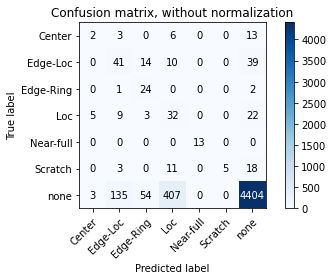

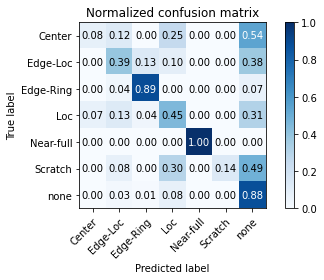

In [22]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix2(y_test_, y_pred_, classes=labels, title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix2(y_test_, y_pred_, classes=labels, normalize=True, title='Normalized confusion matrix')

plt.show()

# **VGGNet**

In [23]:
data_name = 'Bootstrap'
number = '3'
batch_sizes = 64
weight_decay = 1e-4
epochs = 50
model = "VGG"
dir = os.path.join(os.getcwd(),data_name)
os.makedirs(os.path.join(dir,'model_output',number,model), exist_ok=True)
os.makedirs(os.path.join(dir,'train_valid_output',number), exist_ok=True)

In [26]:
def simple_vgg16():
    input_shape = (32, 32, 3)
    input_tensor = Input(input_shape)
    
    #initializer: glorot_normal, glorot_uniform, he_normal, he_uniform

    conv_1 = Conv2D(32, (3,3), kernel_initializer='glorot_uniform', kernel_regularizer=l2(0.001), activation='relu',padding='same')(input_tensor)
    conv_2 = Conv2D(64, (3,3), kernel_initializer='glorot_uniform', kernel_regularizer=l2(0.001), activation='relu',padding='same')(conv_1)
    pool_1 = MaxPool2D((2,2), name = 'max_pool1')(conv_2)

    conv_3 = Conv2D(128, (3,3), kernel_initializer='glorot_uniform',activation='relu', kernel_regularizer=l2(0.001), padding='same')(pool_1)
    conv_4 = Conv2D(256, (3,3), kernel_initializer='glorot_uniform',activation='relu', kernel_regularizer=l2(0.001), padding='same')(conv_3)
    pool_2 = MaxPool2D((2,2), name = 'max_pool2')(conv_4)

    flat = Flatten()(pool_2)

    dense_1 = Dense(512, activation='relu')(flat)
    drop_1 = Dropout(0.4)(dense_1)
    dense_2 = Dense(256, activation='relu')(drop_1)
    output_tensor = Dense(7, activation='softmax')(dense_2)

    model = Model(input_tensor, output_tensor)
 
    return model

In [27]:
model2 = simple_vgg16()
model2.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics=[['AUC', 'Precision','Recall']])
filepath =  os.path.join(dir,'model_output',number,model,'{epoch:03d}.h5')
callbacks_list = [ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_weights_only=False, save_best_only=True, mode='min'),
                  ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_weights_only=False, save_best_only=True, mode='max'),
                  EarlyStopping(monitor='val_auc', patience=3),
                  LearningRateScheduler(lr_schedule,verbose=1)]
auto = model2.fit(x_train, y_train_ohe, validation_data=(x_test, y_test_ohe), epochs=50, batch_size=64, callbacks=callbacks_list, shuffle=True)

Epoch 1/50
Learning rate:  0.0003

Epoch 00001: LearningRateScheduler setting learning rate to 0.0003.
783/783 [==============================] - 35s 39ms/step - loss: 0.5753 - auc: 0.9870 - precision: 0.9290 - recall: 0.8163 - val_loss: 0.4783 - val_auc: 0.9875 - val_precision: 0.9093 - val_recall: 0.8960

Epoch 00001: val_loss improved from inf to 0.47832, saving model to /content/drive/Shareddrives/Labs/2020_1_이소연/code/wm811k/model_output/3/VGG/001.h5
Epoch 2/50
Learning rate:  0.0003

Epoch 00002: LearningRateScheduler setting learning rate to 0.0003.
783/783 [==============================] - 30s 38ms/step - loss: 0.1724 - auc: 0.9991 - precision: 0.9831 - recall: 0.9796 - val_loss: 0.3510 - val_auc: 0.9894 - val_precision: 0.9432 - val_recall: 0.9382

Epoch 00002: val_loss improved from 0.47832 to 0.35096, saving model to /content/drive/Shareddrives/Labs/2020_1_이소연/code/wm811k/model_output/3/VGG/002.h5
Epoch 3/50
Learning rate:  0.0003

Epoch 00003: LearningRateScheduler 

In [29]:
y_predict = model2.predict(x_test)
y_pred_2 = np.ones(len(y_predict))
for i in range(len(y_pred_)):
    y_pred_2[i] = np.argmax(y_predict[i])
print(classification_report(y_test_, y_pred_2, target_names=labels))

              precision    recall  f1-score   support

      Center       0.40      0.50      0.44        24
    Edge-Loc       0.56      0.62      0.59       104
   Edge-Ring       0.63      0.81      0.71        27
         Loc       0.56      0.54      0.55        71
   Near-full       1.00      1.00      1.00        13
     Scratch       0.47      0.24      0.32        37
        none       0.98      0.98      0.98      5003

    accuracy                           0.96      5279
   macro avg       0.66      0.67      0.66      5279
weighted avg       0.96      0.96      0.96      5279



Confusion matrix, without normalization
Normalized confusion matrix


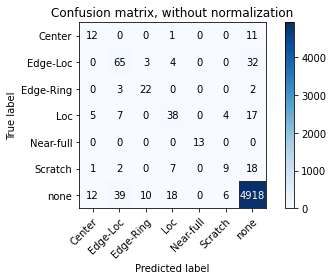

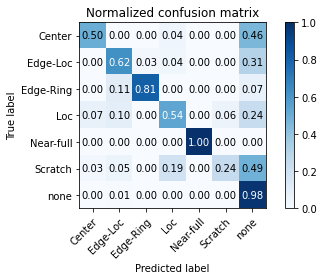

In [32]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix2(y_test_, y_pred_2, classes=labels, title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix2(y_test_, y_pred_2, classes=labels, normalize=True, title='Normalized confusion matrix')

plt.show()

In [33]:
def vgg16_model(img_shape=(224, 224, 3), n_classes=1000, l2_reg=0.,
	weights=None):

	# Initialize model
	vgg16 = Sequential()

	# Layer 1 & 2
	vgg16.add(Conv2D(64, (3, 3), padding='same',
		input_shape=img_shape, kernel_regularizer=l2(l2_reg)))
	vgg16.add(Activation('relu'))
	vgg16.add(ZeroPadding2D((1, 1)))
	vgg16.add(Conv2D(64, (3, 3), padding='same'))
	vgg16.add(Activation('relu'))
	vgg16.add(MaxPooling2D(pool_size=(2, 2)))

	# Layer 3 & 4
	vgg16.add(ZeroPadding2D((1, 1)))
	vgg16.add(Conv2D(128, (3, 3), padding='same'))
	vgg16.add(Activation('relu'))
	vgg16.add(ZeroPadding2D((1, 1)))
	vgg16.add(Conv2D(128, (3, 3), padding='same'))
	vgg16.add(Activation('relu'))
	vgg16.add(MaxPooling2D(pool_size=(2, 2)))

	# Layer 5, 6, & 7
	vgg16.add(ZeroPadding2D((1, 1)))
	vgg16.add(Conv2D(256, (3, 3), padding='same'))
	vgg16.add(Activation('relu'))
	vgg16.add(ZeroPadding2D((1, 1)))
	vgg16.add(Conv2D(256, (3, 3), padding='same'))
	vgg16.add(Activation('relu'))
	vgg16.add(ZeroPadding2D((1, 1)))
	vgg16.add(Conv2D(256, (3, 3), padding='same'))
	vgg16.add(Activation('relu'))
	vgg16.add(MaxPooling2D(pool_size=(2, 2)))

	# Layers 8, 9, & 10
	vgg16.add(ZeroPadding2D((1, 1)))
	vgg16.add(Conv2D(512, (3, 3), padding='same'))
	vgg16.add(Activation('relu'))
	vgg16.add(ZeroPadding2D((1, 1)))
	vgg16.add(Conv2D(512, (3, 3), padding='same'))
	vgg16.add(Activation('relu'))
	vgg16.add(ZeroPadding2D((1, 1)))
	vgg16.add(Conv2D(512, (3, 3), padding='same'))
	vgg16.add(Activation('relu'))
	vgg16.add(MaxPooling2D(pool_size=(2, 2)))

	# Layers 11, 12, & 13
	vgg16.add(ZeroPadding2D((1, 1)))
	vgg16.add(Conv2D(512, (3, 3), padding='same'))
	vgg16.add(Activation('relu'))
	vgg16.add(ZeroPadding2D((1, 1)))
	vgg16.add(Conv2D(512, (3, 3), padding='same'))
	vgg16.add(Activation('relu'))
	vgg16.add(ZeroPadding2D((1, 1)))
	vgg16.add(Conv2D(512, (3, 3), padding='same'))
	vgg16.add(Activation('relu'))
	vgg16.add(MaxPooling2D(pool_size=(2, 2)))

	# Layers 14, 15, & 16
	vgg16.add(Flatten())
	vgg16.add(Dense(4096))
	vgg16.add(Activation('relu'))
	vgg16.add(Dropout(0.5))
	vgg16.add(Dense(4096))
	vgg16.add(Activation('relu'))
	vgg16.add(Dropout(0.5))
	vgg16.add(Dense(n_classes))
	vgg16.add(Activation('softmax'))

	if weights is not None:
		vgg16.load_weights(weights)

	return vgg16

In [34]:
model3 = vgg16_model(img_shape=(32, 32, 3), n_classes=7)
model3.summary()
plot_model(model3, show_shapes=True)

filepath =  os.path.join(dir,'model_output',number,'VGG16','{epoch:03d}.h5')
callbacks_list = [ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_weights_only=False, save_best_only=True, mode='min'),
                  ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_weights_only=False, save_best_only=True, mode='max'),
                  EarlyStopping(monitor='val_auc', patience=3),
                  LearningRateScheduler(lr_schedule,verbose=1)] 
model3.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics=['AUC', 'Precision','Recall'])
auto = model3.fit(x_train, y_train_ohe, validation_data=(x_test, y_test_ohe), epochs=50, batch_size=64, callbacks=callbacks_list, shuffle=True)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
activation (Activation)      (None, 32, 32, 64)        0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 34, 34, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 34, 34, 64)        36928     
_________________________________________________________________
activation_1 (Activation)    (None, 34, 34, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 17, 17, 64)        0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 19, 19, 64)        0

In [35]:
loss=auto.history['loss']
val_loss=auto.history['val_loss']
auc=auto.history['auc']
val_auc=auto.history['val_auc']
precision=auto.history['precision']
val_precision=auto.history['val_precision']
recall=auto.history['recall']
val_recall=auto.history['val_recall']
epochs=range(1,len(loss)+1)

data = np.array([epochs,loss,val_loss,auc,val_auc,precision,val_precision,recall, val_recall]).T

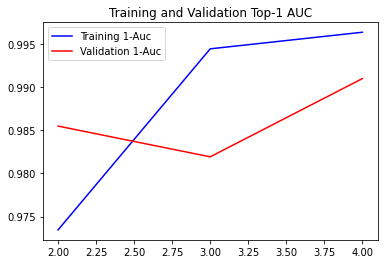

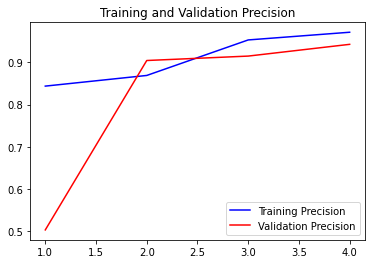

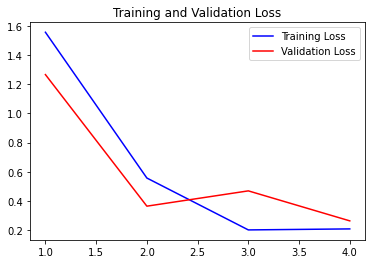

In [36]:
plt.plot(epochs[1:],auc[1:],'b',label='Training 1-Auc')
plt.plot(epochs[1:],val_auc[1:],'r',label='Validation 1-Auc')
plt.title('Training and Validation Top-1 AUC')
plt.legend()
plt.figure()

plt.plot(epochs,precision,'b',label='Training Precision')
plt.plot(epochs,val_precision,'r',label='Validation Precision')
plt.title('Training and Validation Precision')
plt.legend()
plt.figure()

plt.plot(epochs,loss,'b',label='Training Loss')
plt.plot(epochs,val_loss,'r',label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [37]:
y_predict = model3.predict(x_test)
y_pred_3 = np.ones(len(y_predict))
for i in range(len(y_pred_3)):
    y_pred_3[i] = np.argmax(y_predict[i])
print(classification_report(y_test_, y_pred_3, target_names=labels))

              precision    recall  f1-score   support

      Center       0.28      0.62      0.38        24
    Edge-Loc       0.35      0.70      0.47       104
   Edge-Ring       0.56      0.74      0.63        27
         Loc       0.48      0.42      0.45        71
   Near-full       0.81      1.00      0.90        13
     Scratch       0.14      0.46      0.22        37
        none       0.99      0.95      0.97      5003

    accuracy                           0.93      5279
   macro avg       0.52      0.70      0.57      5279
weighted avg       0.96      0.93      0.94      5279



Confusion matrix, without normalization
Normalized confusion matrix


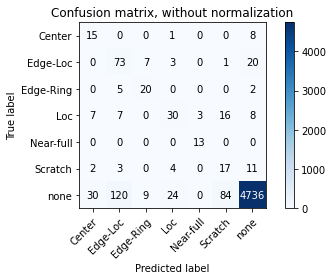

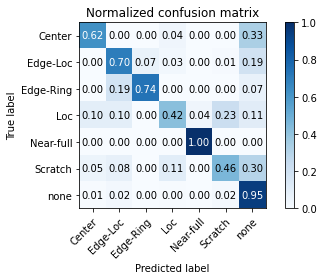

In [38]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix2(y_test_, y_pred_3, classes=labels, title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix2(y_test_, y_pred_3, classes=labels, normalize=True, title='Normalized confusion matrix')

plt.show()

# **ResNet**

ResNet50 / ResNet18

VGG + Class Activation Mapping(CAM) technique

In [44]:
data_name = 'Bootstrap'
number = '0'
batch_sizes = 64
weight_decay = 1e-4
epochs = 50
model = "ResNet"
dir = os.path.join(os.getcwd(),data_name)
os.makedirs(os.path.join(dir,'model_output',number,model), exist_ok=True)
os.makedirs(os.path.join(dir,'train_valid_output',number), exist_ok=True)

In [41]:
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###
    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f,f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1,1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

In [42]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###

    # Second component of main path (≈3 lines)
    X = Conv2D(F2, (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(F3, (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

In [43]:
def ResNet50(input_shape = (27, 27, 3), classes = 9):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((1, 1))(X_input)
    
    # Stage 1
    X = Conv2D(64, (3, 3), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [32,32,128], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [32,32,128], stage=2, block='b')
    X = identity_block(X, 3, [32,32,128], stage=2, block='c')

    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [64,64,256], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [64,64,256], stage=3, block='b')
    X = identity_block(X, 3, [64,64,256], stage=3, block='c')
    X = identity_block(X, 3, [64,64,256], stage=3, block='d')

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [128,128,512], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [128,128,512], stage=4, block='b')
    X = identity_block(X, 3, [128,128,512], stage=4, block='c')
    X = identity_block(X, 3, [128,128,512], stage=4, block='d')
    X = identity_block(X, 3, [128,128,512], stage=4, block='e')
    X = identity_block(X, 3, [128,128,512], stage=4, block='f')

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=5, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=5, block='c')

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D(pool_size=(2,2), name = "avg_pool")(X)
    
    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [45]:
# ResNet50
model5 = ResNet50(input_shape = (32, 32, 3), classes = 7)
model5.summary()
plot_model(model5, show_shapes=True)

filepath =  os.path.join(dir,'model_output',number, model,'{epoch:03d}.h5')
callbacks_list = [ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_weights_only=False, save_best_only=True, mode='min'),
                  ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_weights_only=False, save_best_only=True, mode='max'),
                  EarlyStopping(monitor='val_auc', patience=3),
                  LearningRateScheduler(lr_schedule,verbose=1)] 
model5.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics=['AUC', 'Precision','Recall'])
auto = model5.fit(x_train, y_train_ohe, validation_data=(x_test, y_test_ohe), epochs=50, batch_size=64, callbacks=callbacks_list, shuffle=True)

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_42 (ZeroPadding2 (None, 34, 34, 3)    0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 32, 32, 64)   1792        zero_padding2d_42[0][0]          
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 32, 32, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

In [46]:
y_predict = model5.predict(x_test)
y_pred_5 = np.ones(len(y_predict))
for i in range(len(y_pred_5)):
    y_pred_5[i] = np.argmax(y_predict[i])
print(classification_report(y_test_, y_pred_5, target_names=labels))

              precision    recall  f1-score   support

      Center       0.27      0.29      0.28        24
    Edge-Loc       0.47      0.64      0.54       104
   Edge-Ring       0.72      0.78      0.75        27
         Loc       0.60      0.37      0.46        71
   Near-full       0.93      1.00      0.96        13
     Scratch       0.30      0.22      0.25        37
        none       0.98      0.98      0.98      5003

    accuracy                           0.96      5279
   macro avg       0.61      0.61      0.60      5279
weighted avg       0.96      0.96      0.96      5279



Confusion matrix, without normalization
Normalized confusion matrix


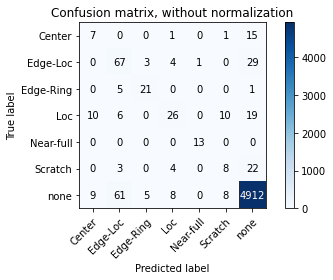

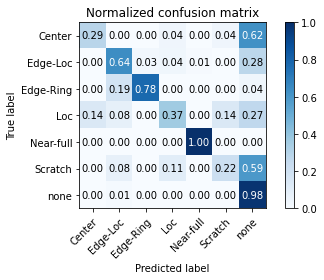

In [47]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix]
plot_confusion_matrix2(y_test_, y_pred_5, classes=labels, title='Confusion matrix, without normalization')

# Plot normalized confusion matrix]
plot_confusion_matrix2(y_test_, y_pred_5, classes=labels, normalize=True, title='Normalized confusion matrix')

plt.show()

# **Inception-resnet-v2**

In [48]:
data_name = 'Bootstrap'
number = '0'
batch_sizes = 32
weight_decay = 1e-4
epochs = 50
model = "Inception"
dir = os.path.join(os.getcwd(),data_name)
os.makedirs(os.path.join(dir,'model_output',number,model), exist_ok=True)
os.makedirs(os.path.join(dir,'train_valid_output',number), exist_ok=True)

In [84]:
def conv2d_bn(x, filters, kernel_size,  strides=1, padding='same', activation='relu', use_bias=False, name=None, weight_decay=weight_decay):
    """Utility function to apply conv + BN.
    # Arguments
        x: input tensor.
        filters: filters in `Conv2D`.
        kernel_size: kernel size as in `Conv2D`.
        padding: padding mode in `Conv2D`.
        activation: activation in `Conv2D`.
        strides: strides in `Conv2D`.
        name: name of the ops; will become `name + '_Activation'`
            for the activation and `name + '_BatchNorm'` for the
            batch norm layer.
    # Returns
        Output tensor after applying `Conv2D` and `BatchNormalization`.
    """
    x = Conv2D(filters,
               kernel_size,
               strides=strides,
               padding=padding,
               use_bias=use_bias,
               name=name)(x)
    if not use_bias:
        bn_axis = 1 if K.image_data_format() == 'channels_first' else 3
        x = BatchNormalization(axis=bn_axis, scale=False)(x)
    if activation is not None:
        x = Activation(activation)(x)
    return x

In [85]:
def inception_resnet_block(x, scale, block_type, block_idx, activation='relu'):
 
    if block_type == 'block35':
        branch_0 = conv2d_bn(x, 32, 1)
        branch_1 = conv2d_bn(x, 32, 1)
        branch_1 = conv2d_bn(branch_1, 32, 3)
        branch_2 = conv2d_bn(x, 32, 1)
        branch_2 = conv2d_bn(branch_2, 48, 3)
        branch_2 = conv2d_bn(branch_2, 64, 3)
        branches = [branch_0, branch_1, branch_2]
    elif block_type == 'block17':
        branch_0 = conv2d_bn(x, 192, 1)
        branch_1 = conv2d_bn(x, 128, 1)
        branch_1 = conv2d_bn(branch_1, 160, [1, 7])
        branch_1 = conv2d_bn(branch_1, 192, [7, 1])
        branches = [branch_0, branch_1]
    elif block_type == 'block8':
        branch_0 = conv2d_bn(x, 192, 1)
        branch_1 = conv2d_bn(x, 192, 1)
        branch_1 = conv2d_bn(branch_1, 224, [1, 3])
        branch_1 = conv2d_bn(branch_1, 256, [3, 1])
        branches = [branch_0, branch_1]
    else:
        raise ValueError('Unknown Inception-ResNet block type. '
                         'Expects "block35", "block17" or "block8", '
                         'but got: {block_type}'.format(block_type=block_type))

    block_name = '{block_type}_{block_idx}'.format(block_type=block_type, block_idx=block_idx)
    channel_axis = 3
    mixed = Concatenate(axis=channel_axis, name='{block_name}_mixed'.format(block_name=block_name))(branches)
    up = conv2d_bn(mixed,
                   K.int_shape(x)[channel_axis],
                   1,
                   activation=None,
                   use_bias=True,
                   name='{block_name}_conv'.format(block_name=block_name))

    x = Lambda(lambda inputs, scale_: inputs[0] + inputs[1] * scale_,
               output_shape=K.int_shape(x)[1:],
               arguments={'scale_': scale},
               name=block_name)([x, up])
    if activation is not None:
        x = Activation(activation, name='{block_name}_ac'.format(block_name=block_name))(x)

    return x

In [90]:
def Inception_ResNet_v2(input_shape=None, weight_decay=weight_decay, classes=8, name=None):
 
    img_input = Input(shape=input_shape)


    # Stem block: 35 x 35 x 192
    x = conv2d_bn(img_input, 32, 3, strides=2, padding='valid')
    x = conv2d_bn(x, 32, 3, padding='valid')
    x = conv2d_bn(x, 64, 3)
    x = MaxPooling2D(3, strides=2)(x)
    x = conv2d_bn(x, 80, 1, padding='valid')
    x = conv2d_bn(x, 192, 3, padding='valid')
    x = MaxPooling2D(3, strides=2)(x)

    # Mixed 5b (Inception-A block): 35 x 35 x 320
    branch_0 = conv2d_bn(x, 96, 1)
    branch_1 = conv2d_bn(x, 48, 1)
    branch_1 = conv2d_bn(branch_1, 64, 5)
    branch_2 = conv2d_bn(x, 64, 1)
    branch_2 = conv2d_bn(branch_2, 96, 3)
    branch_2 = conv2d_bn(branch_2, 96, 3)
    branch_pool = AveragePooling2D(3, strides=1, padding='same')(x)
    branch_pool = conv2d_bn(branch_pool, 64, 1)
    branches = [branch_0, branch_1, branch_2, branch_pool]
    channel_axis = 3
    x = Concatenate(axis=channel_axis, name='mixed_5b')(branches)


    # 10x block35 (Inception-ResNet-A block): 35 x 35 x 320
    for block_idx in range(1, 11):
        x = inception_resnet_block(x,
                                   scale=0.17,
                                   block_type='block35',
                                   block_idx=block_idx)

    # Mixed 6a (Reduction-A block): 17 x 17 x 1088
    branch_0 = conv2d_bn(x, 384, 3, strides=2, padding='same')
    branch_1 = conv2d_bn(x, 256, 1)
    branch_1 = conv2d_bn(branch_1, 256, 3)
    branch_1 = conv2d_bn(branch_1, 384, 3, strides=2, padding='same')
    branch_pool = MaxPooling2D(3, strides=2, padding='same')(x)
    branches = [branch_0, branch_1, branch_pool]
    x = Concatenate(axis=channel_axis, name='mixed_6a')(branches)


    # 20x block17 (Inception-ResNet-B block): 17 x 17 x 1088
    for block_idx in range(1, 21):
        x = inception_resnet_block(x,
                                   scale=0.1,
                                   block_type='block17',
                                   block_idx=block_idx)

    # Mixed 7a (Reduction-B block): 8 x 8 x 2080
    branch_0 = conv2d_bn(x, 256, 1)
    branch_0 = conv2d_bn(branch_0, 384, 3, strides=2, padding='same')
    branch_1 = conv2d_bn(x, 256, 1)
    branch_1 = conv2d_bn(branch_1, 288, 3, strides=2, padding='same')
    branch_2 = conv2d_bn(x, 256, 1)
    branch_2 = conv2d_bn(branch_2, 288, 3)
    branch_2 = conv2d_bn(branch_2, 320, 3, strides=2, padding='same')
    branch_pool = MaxPooling2D(3, strides=2, padding='same')(x)
    branches = [branch_0, branch_1, branch_2, branch_pool]
    x = Concatenate(axis=channel_axis, name='mixed_7a')(branches)


    # 10x block8 (Inception-ResNet-C block): 8 x 8 x 2080
    for block_idx in range(1, 10):
        x = inception_resnet_block(x,
                                   scale=0.2,
                                   block_type='block8',
                                   block_idx=block_idx)
    x = inception_resnet_block(x,
                               scale=1.,
                               activation=None,
                               block_type='block8',
                               block_idx=10)

    # Final convolution block: 8 x 8 x 1536
    x = conv2d_bn(x, 1536, 1, name='conv_7b')

    x = GlobalAveragePooling2D(name='avg_pool')(x)
    x = Dense(classes, use_bias=False, kernel_regularizer=l2(weight_decay), activation='softmax', name='predictions')(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`
    inputs = img_input

    # Create model
    model = Model(inputs, x, name=name)

    return model

In [91]:
model6 = Inception_ResNet_v2(input_shape = (32, 32, 3), weight_decay=weight_decay, classes=7, name='Inception_ResNet_v2')
model6.summary()
plot_model(model6, show_shapes=True)
filepath =  os.path.join(dir,'model_output',number, model,'{epoch:03d}.h5')
callbacks_list = [ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_weights_only=False, save_best_only=True, mode='min'),
                  ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_weights_only=False, save_best_only=True, mode='max'),
                  EarlyStopping(monitor='val_auc', patience=3),
                  LearningRateScheduler(lr_schedule,verbose=1)] 
model6.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics=['AUC', 'Precision','Recall'])
auto = model6.fit(x_train, y_train_ohe, validation_data=(x_test, y_test_ohe), epochs=50, batch_size=32, callbacks=callbacks_list, shuffle=True, steps_per_epoch=int(len(x_train)/batch_sizes),  validation_steps=int(len(x_test)/batch_sizes)))

Model: "Inception_ResNet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_784 (Conv2D)             (None, 15, 15, 32)   864         input_18[0][0]                   
__________________________________________________________________________________________________
batch_normalization_721 (BatchN (None, 15, 15, 32)   96          conv2d_784[0][0]                 
__________________________________________________________________________________________________
activation_824 (Activation)     (None, 15, 15, 32)   0           batch_normalization_721[0][0]    
________________________________________________________________________________

In [96]:
y_predict = model6.predict(x_test)
y_pred_6 = np.ones(len(y_predict))
for i in range(len(y_pred_5)):
    y_pred_6[i] = np.argmax(y_predict[i])
print(classification_report(y_test_, y_pred_6, target_names=labels))

              precision    recall  f1-score   support

      Center       0.30      0.38      0.33        24
    Edge-Loc       0.41      0.34      0.37       104
   Edge-Ring       0.74      0.52      0.61        27
         Loc       0.48      0.44      0.46        71
   Near-full       1.00      1.00      1.00        13
     Scratch       0.30      0.22      0.25        37
        none       0.97      0.98      0.98      5003

    accuracy                           0.95      5279
   macro avg       0.60      0.55      0.57      5279
weighted avg       0.95      0.95      0.95      5279



Confusion matrix, without normalization
Normalized confusion matrix


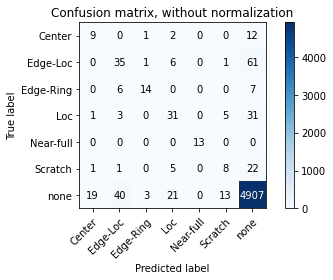

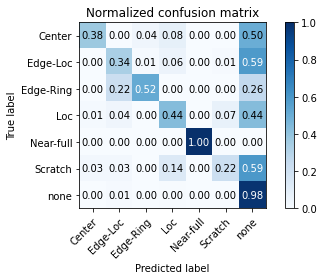

In [97]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix]
plot_confusion_matrix2(y_test_, y_pred_6, classes=labels, title='Confusion matrix, without normalization')

# Plot normalized confusion matrix]
plot_confusion_matrix2(y_test_, y_pred_6, classes=labels, normalize=True, title='Normalized confusion matrix')

plt.show()

# **Denoising AE**

In [ ]:
# denoising autoencoder
noise = np.random.normal(loc=0.5, scale=0.5, size=x_train.shape)
x_train_noise = x_train + noise
noise = np.random.normal(loc=0.5, scale=0.5, size=x_test.shape)
x_test_noise = x_test + noise

encoder = Model(input_tensor, latent_vector)
decoder_input = Input((16, 16, 64))
decode = Conv2DTranspose(64, (3,3), padding='same', activation='relu')(decoder_input)
decode = UpSampling2D()(decode)
decoder = Model(decoder_input, output_tensor(decode))

noise = Model(input_tensor, decoder(encoder(input_tensor)))
noise.summary()
noise.compile(loss='mse', optimizer='adam', metrics=['AUC'])
noise.fit(x_train_noise,x_train, validation_data=(x_test_noise, x_test), epochs=10, batch_size=64, callbacks=callback_list)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
model_1 (Functional)         (None, 16, 16, 64)        1792      
_________________________________________________________________
model_2 (Functional)         (None, 32, 32, 3)         38659     
Total params: 40,451
Trainable params: 40,451
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
89/89 [==============================] - 4s 35ms/step - loss: 0.0818 - auc: 0.9319 - val_loss: 0.0527 - val_auc: 0.9781
Epoch 2/10
89/89 [==============================] - 3s 31ms/step - loss: 0.0474 - auc: 0.9824 - val_loss: 0.0438 - val_auc: 0.9848
Epoch 3/10
89/89 [==============================] - 3s 31ms/step - loss: 0.0414 - auc: 0.9864 - val_loss: 0.0393 - val_auc:

In [ ]:
np.where(y_test=='Scratch')

(array([ 291,  299,  516,  656,  836, 1657, 1843, 2286, 2341, 2353, 2376]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

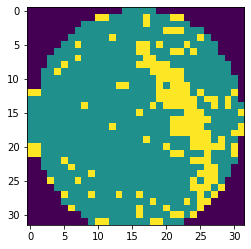

In [ ]:
plt.imshow(np.argmax(x_test[291], axis=2))

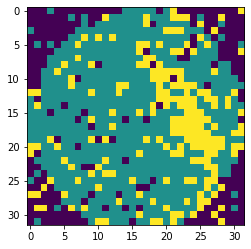

In [ ]:
plt.imshow(np.argmax(x_test_noise[291], axis=2)) 

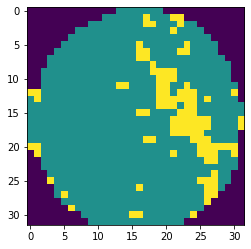

In [ ]:
x_noise = noise.predict(x_test_noise) 
plt.imshow(np.argmax(x_noise[291], axis=2))

# **Variational AE**

In [ ]:
# variational autoencoder
batch_size = 100
original_dim = 128*128
latent_dim = 3
epochs = 50
epsilon_std = 1.0


x = Input(shape=(original_dim,))
h = Dense(128)(x)
#h = BatchNormalization()(h)
h = Activation('relu')(h)
h = Dense(64)(h)
#h = BatchNormalization()(h)
h = Activation('relu')(h)
h = Dense(32)(h)
#h = BatchNormalization()(h)
h = Activation('relu')(h)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

decoder_h = Dense(32, activation='relu')
decoder_h2 = Dense(64, activation='relu')
decoder_h3 = Dense(128, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
h_decoded = decoder_h2(h_decoded)
h_decoded = decoder_h3(h_decoded)
x_decoded_mean = decoder_mean(h_decoded)

loss_log = []

class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x, x_decoded_mean):
        xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
        kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        x_decoded_mean = inputs[1]
        loss = self.vae_loss(x, x_decoded_mean)
        self.add_loss(loss, inputs=inputs)
        # We won't actually use the output.
        return x

y = CustomVariationalLayer()([x, x_decoded_mean])
vae = Model(x, y)
vae.compile(optimizer='rmsprop', loss=None)

x_train = load_wafers('clean2_train')
x_train = (x_train + 1) / 2
#x_train = x_train.reshape(x_train.shape[0], 128, 128)
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))

In [ ]:
vae.fit(x_train,
        shuffle=True,
        epochs=100,
        batch_size=batch_size)